In [2]:
from keras.models import Sequential  
from keras.layers import Dense, Flatten, Conv2D
import keras
from collections import deque 
import numpy as np
import gym 
env = gym.make('Breakout-v0')  
import random

In [3]:
model = Sequential()
model.add(Conv2D(24, 6, input_shape=(2,) + env.observation_space.shape, kernel_initializer='uniform', activation='relu'))
model.add(Conv2D(48, 3, activation='relu'))
model.add(Flatten())       # Flatten input so as to have no problems with processing
model.add(Dense(48, kernel_initializer='uniform', activation='relu'))
model.add(Dense(24, kernel_initializer='uniform', activation='relu'))
model.add(Dense(env.action_space.n, kernel_initializer='uniform', activation='linear'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [5]:
D = deque()
observetime = 500
epsilon = 1
epsilon_decay = 0.004
gamma = 0.9
mb_size = 50
# Statistics to save
timesFinished = 0
rewardTrack =[]
maxVel=0
maxPos=0

In [6]:
observation = env.reset() 
obs = np.expand_dims(observation, axis=0) 
state = np.stack((obs, obs), axis=1)
done = False
maxReward = 0
epochs = 35

for epoch in range(epochs):
    print("EPOCH: {}".format(epoch))
    print("Epsilon {}".format(epsilon))
    D = deque()
    for t in range(observetime):
        # env.render()
        # if(((t/observetime)*100)%5 == 0):
        #     print("{}%".format(100*t/observetime))
        # if (t==observetime/2):
        #     print("Half")
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, env.action_space.n, size=1)[0]
#             epsilon*=0.95
        else:
            Q = model.predict(state)
            action = np.argmax(Q)
            action = np.random.randint(0, env.action_space.n, size=1)[0]
        observation_new, reward, done, info = env.step(action)
        
        if reward > maxReward:
            print(reward)
            maxReward = reward
        obs_new = np.expand_dims(observation_new, axis=0)          
        state_new = np.append(np.expand_dims(obs_new, axis=0), state[:, :1, :], axis=1)     
        D.append((state, action, reward, state_new, done))         
        state = state_new         
        if done:
            maxVel=0
            maxPos=0
            env.reset()           
            obs = np.expand_dims(observation, axis=0)      
            state = np.stack((obs, obs), axis=1)
    print('Observing Finished')

    # mb_size = 250

    for iteration in range (3):
        minibatch = random.sample(D, mb_size)                              
        inputs_shape = (mb_size,) + state.shape[1:]
        inputs = np.zeros(inputs_shape)
        targets = np.zeros((mb_size, env.action_space.n))
        print(iteration)
        for i in range(0, mb_size):
            # if(((i/mb_size)*100)%50 == 0):
            #     print("{}%".format(100*i/mb_size))
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            state_new = minibatch[i][3]
            done = minibatch[i][4]
            inputs[i:i+1] = np.expand_dims(state, axis=0)
            targets[i] = model.predict(state)
            Q_sa = model.predict(state_new)

            if done:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + gamma * np.max(Q_sa)

        model.train_on_batch(inputs, targets)
    epsilon -= epsilon_decay
    if epsilon < 0.01:
        epsilon = 0.01
    print('Learning Finished')

EPOCH: 0
Epsilon 1
Observing Finished
0
1
2
Learning Finished
EPOCH: 1
Epsilon 0.996
1.0
Observing Finished
0
1
2
Learning Finished
EPOCH: 2
Epsilon 0.992
Observing Finished
0
1
2
Learning Finished
EPOCH: 3
Epsilon 0.988
Observing Finished
0
1
2
Learning Finished
EPOCH: 4
Epsilon 0.984
Observing Finished
0
1
2
Learning Finished
EPOCH: 5
Epsilon 0.98
Observing Finished
0
1
2
Learning Finished
EPOCH: 6
Epsilon 0.976
Observing Finished
0
1
2
Learning Finished
EPOCH: 7
Epsilon 0.972
Observing Finished
0
1
2
Learning Finished
EPOCH: 8
Epsilon 0.968
Observing Finished
0
1
2
Learning Finished
EPOCH: 9
Epsilon 0.964
Observing Finished
0
1
2
Learning Finished
EPOCH: 10
Epsilon 0.96
Observing Finished
0
1
2
Learning Finished
EPOCH: 11
Epsilon 0.956
Observing Finished
0
1
2
Learning Finished
EPOCH: 12
Epsilon 0.952
Observing Finished
0
1
2
Learning Finished
EPOCH: 13
Epsilon 0.948
Observing Finished
0
1
2
Learning Finished
EPOCH: 14
Epsilon 0.944
Observing Finished
0
1
2
Learning Finished
EPOCH: 

In [12]:
observation = env.reset()
obs = np.expand_dims(observation, axis=0)
state = np.stack((obs, obs), axis=1)
done = False
tot_reward = 0.0  
env.step(1)  
while not done:
    env.render()
    Q = model.predict(state)        
    action = np.argmax(Q)         
    observation, reward, done, info = env.step(action)
    obs = np.expand_dims(observation, axis=0)
    state = np.append(np.expand_dims(obs, axis=0), state[:, :1, :], axis=1)    
    tot_reward += reward
    rewardTrack.append(tot_reward)
print('Game ended! Total reward: {}'.format(tot_reward))

KeyboardInterrupt: 

In [13]:
env.close()

In [8]:
model.save('MSIDLA')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MSIDLA\assets


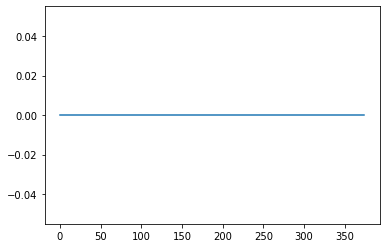

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(len(rewardTrack)), rewardTrack)
plt.show()